# Byzantine Generals Turn to Quantum
## *At four, they now unmask at once two traitors among them*



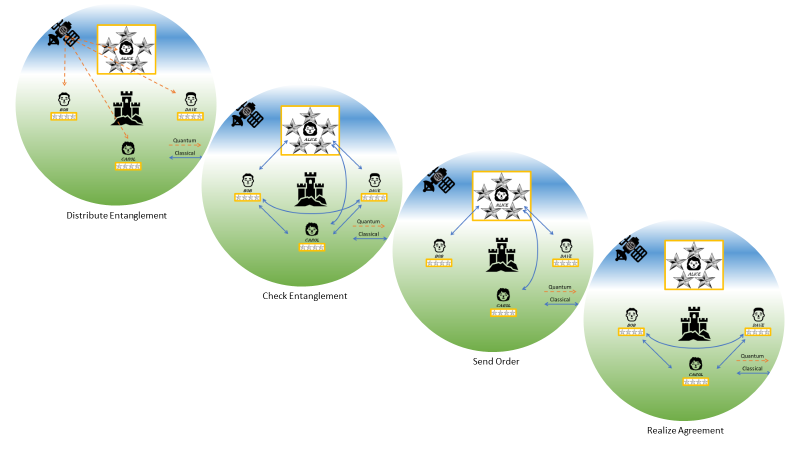
#### Notes:

This version uses a prediction of the errors in the game in function of the device, the circuit, the order, the lieutenant and his loyalty.

As an option, agreement is obtained using a Bayesian model where loyal lieutenants have an a priori estimate of each general's probability of cheating.

The "byzantine mitigation" in the case of more than 4 generals which consists of flipping half of the bitstrings is now done randomly (instead of each bitstring with an even index as mentioned in the [article published in
Geek Culture](https://medium.com/geekculture/byzantine-generals-turn-to-quantum-ab81bd938cc2)). This involves sharing between generals the indexes of the bitstrings to be flipped. The condition therefore remains that each party knows only her/his result list when ultimately realizing agreement.

In [29]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram
import copy, random, itertools
from qiskit.quantum_info.analysis import hellinger_fidelity

In [30]:
# define here the distance/distribution used to unmask traitor
from scipy.spatial.distance import sqeuclidean as distance
from scipy.stats import hypergeom

In [31]:
# parameters
noise = True
simulator = Aer.get_backend('qasm_simulator')
optimization_level = 2
shots = 8192
max_rounds = 500
verbose_flag = False

# number of generals
N_gen = 4

# use hypergeometric distribution, or distance otherwise
hg_flag = True

# here you can change the backends
from qiskit.test.mock import FakeSantiago as device_3_generals
from qiskit.test.mock import FakeSydney as device_4_generals

In [32]:
# adapt to given parameters
if N_gen == 3:
    perms = list(itertools.permutations(['00','01','10'], r=3))
    device = device_3_generals

elif N_gen == 4:
    perms = list(itertools.permutations(['00','01','10','11'], r=4))
    device = device_4_generals
    
else: 
    print("only the three and four generals cases considered at this time")

if noise:
    backend = AerSimulator.from_backend(device())
else: # switch to the ideal device
    backend = simulator

In [33]:
backend.name()

'aer_simulator(fake_sydney)'

#### Prepare the state:


In case of three generals:

$$ \frac{1}{2\;\sqrt3}\; (\;2\;|0011\rangle - |0101\rangle - |0110\rangle - |1001\rangle -  |1010\rangle + 2\;|1100\rangle\;) $$


In case of four generals:


$$(\sqrt6|00111\rangle +  |01001\rangle +  |01010\rangle + |01100\rangle + |10011 \rangle +  |10101\rangle +  |10110\rangle +  \sqrt6|11100\rangle) \ /\sqrt18$$

In [34]:
if N_gen == 3:
    init_list = np.array([0., 0., 0., 2., 0., -1., -1., 0.,
             0., -1., -1., 0., 2., 0., 0., 0.]) / ( 2*np.sqrt(3) )
elif N_gen == 4:
    init_list = np.array(  [0., 0., 0., 0., 0., 0., 0., 6.**.5,
                            0., +1., +1., 0., +1., 0., 0., 0.,
                            0., 0., 0., +1., 0., +1., +1., 0.,
                            6.**.5, 0., 0., 0., 0., 0., 0., 0.]) / np.sqrt(18)
else: 
    print("only the three and four generals cases considered at this time")

In [35]:
# create the quantum circuit
circuit = QuantumCircuit(N_gen+1)

circuit.initialize(init_list, circuit.qubits)

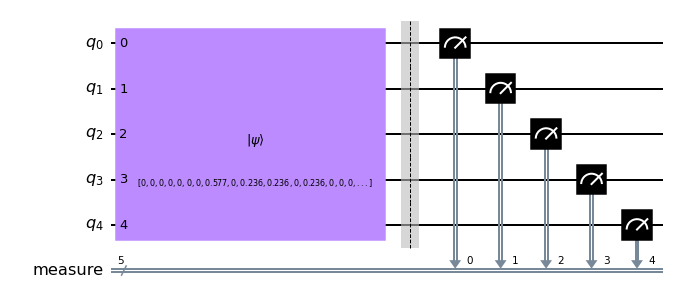

In [36]:
# add Pauli-Z measurements and draw the circuit
circuit.measure_active()
circuit.draw(output='mpl')

In [37]:
# if more details are requested (more .decompose() may be added)
#qasm_circuit = circuit.decompose().decompose() 
#qasm_circuit.draw(output='mpl', fold = 20 - N_gen , plot_barriers=False,
                  #style = {'backgroundcolor': 'cyan'})                                             

## game functions

In [38]:
# byzantine traitor game serving function

def play(k_list, t_list, n_its_list, used_list, stop_flag, flag_y = None):
    flag_1 = True
    flag_2 = True
    
    retry = True
    while retry:
        k = k_list[-1]
        if k in used_list:
            k_list.pop()
            if k_list == []: 
                stop_flag = True
                return flag_1, flag_2
        else:
            retry = False
            used_list.append(k)
    
    if k in t_list:
        flag_1 = False

    if n_its_list[k] == flag_y: 
        flag_2 = False

    return flag_1, flag_2

In [39]:
def traitor_game(players, verbose = False):
    # start playing
    
    game_rounds = 0
    toss = random.randrange(2)
    head = tail = 0
    gen[players[toss]]['failed'] = 0
    gen[players[1-toss]]['failed'] = 0
    
    mat_t = gen[players[toss]]['mat']
    n_its_toss = n_its[mat_t:mat_t+1][0]
    mat_nt = gen[players[1-toss]]['mat']
    n_its_notoss = n_its[mat_nt:mat_nt+1][0]
    
    flag = np.ones((2, 2), dtype=bool)
    used_list = []
    stop_flag = False
    print("\nByzantine traitor game. First to play is", gen[players[toss]]['name'])
    print("                        Second to play is", gen[players[1-toss]]['name'])    
    
    if verbose:
        print( "shots:", shots )
        print(len(gen[players[toss]]['k_list']), "in "  + gen[players[toss]]['name'] + ' list:', 
                   sorted(gen[players[toss]]['k_list']) )   
        print(len(gen[players[1-toss]]['k_list']), "in "  + gen[players[1-toss]]['name'] + ' list:', 
                   sorted(gen[players[1-toss]]['k_list']) )    
    
    while len(gen[players[toss]]['k_list']) > 0 and game_rounds < max_rounds\
            and len(gen[players[1-toss]]['k_list']) > 0 and not stop_flag:
        
        game_rounds += 1        
        
        # first to play
        flag[0][1], flag[1][1] = play(gen[players[toss]]['k_list'],
                                   gen[players[1-toss]]['t_list'],
                                   n_its_notoss, used_list, stop_flag,
                                      gen[players[toss]]['flag_y'])
        
        if not flag[0][1] or not flag[1][1]:                          
            head +=1
        
        gen[players[toss]]['k_list'].pop()

        # second to play
        if not stop_flag: 
            
            flag[0][0], flag[1][0] = play(gen[players[1-toss]]['k_list'],
                                       gen[players[toss]]['t_list'],
                                       n_its_toss, used_list, stop_flag,
                                          gen[players[1-toss]]['flag_y'])

            if not flag[0][0] or not flag[1][0]:                                     
                tail += 1

            gen[players[1-toss]]['k_list'].pop()    
    
    if verbose:
        print(len(used_list), "ind in used_list", sorted(used_list) ) 
    
    print("rounds:", game_rounds)
    
    print(gen[players[1-toss]]['name'] + " counted that " +\
           gen[players[toss]]['name'] + " failed " + str(head)\
           + " times: " + "{:.0%}".format(head / game_rounds))
              
    
    print(gen[players[toss]]['name'] + " counted that " +\
           gen[players[1-toss]]['name'] + " failed " + str(tail)\
           + " times: " + "{:.0%}".format(tail / game_rounds))
    
    return game_rounds, head, tail, toss

## Start experiments
### distribute entaglement

In [40]:
# distribute entanglement 
if noise:
    job_ideal = execute(circuit, backend = simulator, shots = shots,                
                optimization_level = optimization_level)
    
    res_ideal = job_ideal.result()
    counts_ideal = res_ideal.get_counts(circuit)

    if shots <= 200: # for checks
        verbose_flag = True

    if N_gen == 3:    
        job = execute(circuit, backend = backend, shots = shots,
        memory=True,     
        optimization_level = optimization_level)
        figsize = (14,7)
        
    elif N_gen == 4:
        job = execute(circuit, backend = backend, shots = shots,
        memory=True,
        optimization_level = optimization_level)
        figsize = (10,6) 
   
    else: 
        job = None
        print("only the three and four generals cases considered at this time")

    results = job.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    legend_to_plot = [simulator, backend.name()]
    counts_to_plot = [counts_ideal,counts]
    print('hellinger fidelity: {:.1%}'.format(
        hellinger_fidelity(counts_ideal,counts)))
else:
    job_ideal = execute(circuit, backend = simulator, shots = shots,
                        memory = True,
                        optimization_level = optimization_level)
    results = job_ideal.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    legend_to_plot = [backend.name()]
    counts_to_plot = [counts]
    figsize = None

hellinger fidelity: 66.9%


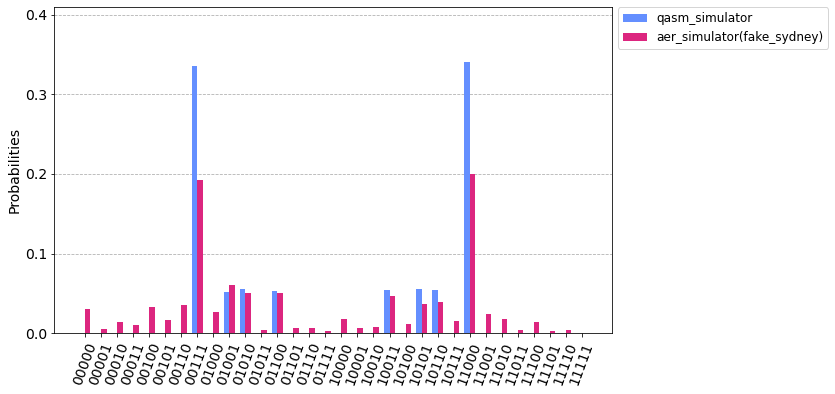

In [41]:
plot_histogram(counts_to_plot, bar_labels = False,
                   figsize = figsize,
                   legend = legend_to_plot)

###   check if the entangled states are not corrupt
 
Mutual verification.

In this phase, the parties can make a prediction of game error rates in function of the device, the circuit, the order, the lieutenant, and his loyalty. This shared knowledge is first used to determine the optimal lengths of Alice's lists, in order that a traitorous lieutenant has the lower probability of success in the game.  At the end, the  discrimination between commanding general or lieutenant as traitor is also improved.

In [42]:
# take a part of the results for check
frac_kept = 3/4 # fraction used for the game
test_i = list(range(shots))
random.shuffle(test_i)
test_i = test_i[:int(shots*(1-frac_kept))]

In [43]:
random_flag = False
if N_gen > 3:
    random_flag = True

In [44]:
def flip(binary_str):    
    return ''.join('0' if i == '1' else '1' for i in binary_str)

In [45]:
# Byzantine mitigation in case of more than 3 generals:
if N_gen > 3:
    bit_strings = []
    for bitstring in memory:
        if random_flag and random.randrange(2) == 1:
            bit_strings.append(flip(bitstring))
        else:
            bit_strings.append((bitstring))
else:
    bit_strings = memory

In [46]:
# get an array for gaming
n_its = np.zeros((N_gen,int(shots*frac_kept))).astype(int)

# convert bitstrings to n_its and store them 

v_dic = {'00': 0, '01': 2,  '10': 2,  '11' : 1, '0' :  0, '1' : 1}

game_i = -1
for j, bitstring in enumerate(bit_strings):
    if j not in test_i:
        game_i += 1
        n_its[0][game_i] = v_dic[bitstring[0:2]] # Alice
        n_its[1][game_i] = v_dic[bitstring[2:3]] # Bo[tossb]
        n_its[2][game_i] = v_dic[bitstring[3:4]] # Charlie
        if N_gen == 4:
            n_its[3][game_i] = v_dic[bitstring[4:5]] # Dave

In [47]:
# define staff

# pi_t is the probability to be a traitor (used for Bayesian model of agreement)
# this prior is used by loyal lieutenants

# if pi_t is the same for the commanding general and a lieutenant,
# this is a non-informative prior for determing who of them is the traitor
# NB: avoid 0.0 for pi_t values, use instead very low values if wanted.

gen = { 'A': { "mat" : 0, 'name': 'Alice', 'pi_t' : 0.01}, 
        'B': { "mat" : 1, 'name': 'Bob', 'pi_t' : 0.01},
        'C': { "mat" : 2, 'name': 'Carol', 'pi_t' : 0.01} }
if N_gen == 4 :       
        gen['D'] = { "mat" : 3,'name': 'Dave', 'pi_t' : 0.01} 

In [48]:
# game-error prediction on the test fraction

lnt_list = list(range(N_gen-1))
lnt_permutations = list(itertools.permutations(lnt_list, r=2))
n_success = np.ones( (N_gen-1, N_gen-1, 2, 3) )
n_trial = np.ones( (N_gen-1, N_gen-1, 2, 3) )

for j, bitstring in enumerate(bit_strings):
    if j in test_i:
        for pair in lnt_permutations:            
            for order in range(2):
                # honest lieutenant 
                if bitstring[0:2] == str(order) + str(order):
                    n_trial[pair[0], pair[1], order, 0] += 1
                    if bitstring[pair[0]+2] == str(1-order):
                        n_success[pair[0], pair[1], order, 0] += 1
                # traitor        
                else:
                    if bitstring[pair[1]+2] == str(order):
                        n_trial[pair[0], pair[1], order, 1] += 1
                        if bitstring[pair[0]+2] == str(order):
                            n_success[pair[0], pair[1], order, 1] += 1   

                    elif bitstring[pair[1]+2] == str(1-order):    
                        n_trial[pair[0], pair[1], order, 2] += 1                
                        if bitstring[pair[0]+2] == str(order):
                            n_success[pair[0], pair[1], order, 2] += 1                   

p = n_success/n_trial
q = 1 - p

In [49]:
# determine the optimal lengths of Alice's lists 
# (only for the case of 3 generals)
if N_gen == 3:
    n_out = np.zeros((2, 2))
    for ln in range(0,2):
        for order in range(2):
            n_out[ln, order] = n_trial[1-ln, ln, order, 2] \
              * (p[1-ln, ln, order, 1] - p[1-ln, ln, order, 2]) \
              / (q[1-ln, ln, order, 0] - p[1-ln, ln, order, 1])
    n_out_m = np.round(np.mean(n_out, axis=0) * (frac_kept)/(1-frac_kept)).astype(int)

    # check: compute expected traitor error after optimized Alice's trit-list length
    new_p = np.zeros((2, 2))
    old_p = np.zeros((2, 2))
    n_check = np.round(np.mean(n_out, axis=0)) # mean because Alice doesn't now who is the traitor
    for ln in range(0,2):
        for order in range(2):
            old_p [ln, order] = p[1-ln, ln, order, 1] # traitor uses only one trit favour 
            new_p[ln, order] = (n_success[1-ln, ln, order, 1] + n_success[1-ln, ln, order, 2] \
                                     + q[1-ln, ln, order, 0] * n_check[order]) \
                                     / (n_trial[1-ln, ln, order, 1] + n_trial[1-ln, ln, order, 2] \
                                     + n_check[order]) # the mix of favours has now same error rate
    new_p - old_p  # must be small     

In [50]:
# prepare an error-rate dictionary for the agreement phase

pair_list = []
gen_list = []
for key in list(gen.keys())[1:N_gen]:
    gen_list.append(key)
for pair in list(itertools.permutations(gen_list, r=2)):
    pair_list.append(str(pair[0]) + str(pair[1]))     

predict = {}
for i, pair in enumerate(lnt_permutations): 
      predict[pair_list[i]] = [q[pair[0]][pair[1]][0][0],
                               q[pair[0]][pair[1]][1][0],
                               q[pair[0]][pair[1]][0][1],
                               q[pair[0]][pair[1]][1][1] ]

In [51]:
# for hypergeometric distribution
n_failure = n_trial - n_success
n_hg = {}
for i, pair in enumerate(lnt_permutations): 
      n_hg[pair_list[i]] = [n_failure[pair[0]][pair[1]][0][0],
                               n_failure[pair[0]][pair[1]][1][0],
                               n_failure[pair[0]][pair[1]][0][1],
                               n_failure[pair[0]][pair[1]][1][1] ]

M_hg = {}
for i, pair in enumerate(lnt_permutations): 
      M_hg[pair_list[i]] = [n_trial[pair[0]][pair[1]][0][0],
                               n_trial[pair[0]][pair[1]][1][0],
                               n_trial[pair[0]][pair[1]][0][1],
                               n_trial[pair[0]][pair[1]][1][1] ]

In [52]:
def hpg_pmf(M, n, N, x):
    return hypergeom(M, n, N).pmf(x)

### use the results to solve the problem

In [56]:
# define scenario

gen['A']['faithful'] = False
gen['A']['target'] = None

gen['B']['faithful'] = True
gen['B']['target'] = True

gen['C']['faithful'] = True
gen['C']['target'] = False

if N_gen == 4 :       
    gen['D']['faithful'] = False
    gen['D']['target'] = False

In [57]:
# check here the number of traitors
 
for key in list(gen.keys())[1:N_gen]:
    if not gen[key]['faithful'] and gen[key]['target']:           
        print("A lieutenant cannot be traitor himself and target of a traitorous commander") 
        print("Please correct the scenario")

traitor_counter = 0
for key in list(gen.keys())[0:N_gen]:    
    if not gen[key]['faithful']:
        traitor_counter += 1

print("Scenario with " + str(N_gen) + " generals and " + str(traitor_counter) + " traitor(s)")

if traitor_counter > N_gen -2 :
    print("No more than " + str(N_gen-2) + " traitor(s) allowed for "\
          + str(N_gen) + " generals, even with quantum power") 
    print("Please correct the scenario")    

Scenario with 4 generals and 2 traitor(s)


In [58]:
# Alice determine the message: 0 for retreat, 1 for attack
m = 1
max_rounds = 500

print("Scenario run on " + backend.name())
print("generals:", list(map(lambda v: v["name"],gen.values()))[0:N_gen])
print("faithful:  ", list(map(lambda v: v["faithful"],gen.values()))[0:N_gen])
print("  target:  ", list(map(lambda v: v["target"],gen.values()))[0:N_gen])

if m == 1:
    print("Order is to attack")
else :
    print("Order is to retreat")

gen['A']['message'] = m
# Alice establishes the corresponding list of indices 
# and the corresponding cheating list

j_list_A = []
j_list_Ac = []
mat = gen['A']['mat']
for k in range(int(shots*frac_kept)):
    val_it = n_its[mat:mat+1][0][k]
    if val_it == m:
        j_list_A.append(k)
    elif val_it == 1 - m:
        j_list_Ac.append(k)

# optimal lengths of Alice's list
if N_gen == 3: 
    random.shuffle(j_list_A)
    j_list_A = j_list_A[n_out_m[m]:]

    random.shuffle(j_list_Ac)
    j_list_Ac = j_list_Ac[n_out_m[1-m]:]

    j_list_A.sort()
    j_list_Ac.sort()

gen['A']['j_list'] = copy.deepcopy(j_list_A)

# Alice send her messages and corresponding lists 
# by pairwise authenticated classical and quantum channels

for key in list(gen.keys())[1:N_gen]:
    if (not gen['A']['faithful']) and gen[key]['target']:
        gen[key]['message'] = 1 - m    
        gen[key]['j_list'] = copy.deepcopy(j_list_Ac )
    else:
        gen[key]['message'] = m    
        gen[key]['j_list'] = copy.deepcopy(j_list_A) 
            
for key in list(gen.keys())[1:N_gen]:
    gen[key]['flag_y'] = gen[key]['message']

# false flag by traitors:
for key in list(gen.keys())[1:N_gen]:
    if gen[key]['faithful']:
        # lieutenant uses commander list in game
        gen[key]['t_list'] = copy.deepcopy(gen[key]['j_list'])
    else:
        gen[key]['flag_y'] = 1 - gen[key]['flag_y']
        # lieutenant uses complement of commander's list in game
        gen[key]['t_list'] = list( set(range(int(shots*frac_kept))) - set(gen[key]['j_list']) )

# prepare for treator game

p_list = []
    
for key in list(gen.keys())[1:N_gen]:

    # add to player's list:            
    if gen[key]['flag_y'] != 3: 
        p_list.append(key)

# check if treator game possible
if len(p_list) == 1:
    print("Only one lieutenant has consistent order") 

elif len(p_list) == 0:
    print("No lieutenant has consistent order")
    
else: # treator game:
        
    res_traitor = {}
    res_N_hg = {}
    res_x_hg = {}
    
    for players in list(itertools.combinations(p_list, r=2)):
        
        if gen[players[0]]['flag_y'] == gen[players[1]]['flag_y']:
            print("\nNo game between " + gen[players[0]]['name']\
             + " and " + gen[players[1]]['name'] + "\nThey say they got the same order from " + gen['A']['name'])
            res_traitor[players[0] + players[1]] = -1.0
            res_traitor[players[1] + players[0]] = -1.0
        
        else:
            # prepare indices list
                
            for key in players:                  
                mat = gen[key]['mat']

                gen[key]['k_list'] = [] 
                
                for k in range(int(shots*frac_kept)):
                    n_it = n_its[mat:mat+1][0][k]                        
                    if (k in gen[key]['t_list']):
                            if gen[key]['faithful'] or N_gen == 3\
                              or (N_gen == 4 and n_it == 1 - gen[key]['flag_y']):
                                gen[key]['k_list'].append(k)
                        
                random.shuffle(gen[key]['k_list'])
                      
                
            game_rounds, head, tail, toss = traitor_game(players, verbose_flag)
            
            # for use of distances
            res_traitor[players[1-toss] + players[toss]] = head / game_rounds
            res_traitor[players[toss] + players[1-toss]] = tail / game_rounds
            
            # for use of hypergeometric distributions
            res_N_hg[players[1-toss] + players[toss]] = game_rounds
            res_N_hg[players[toss] + players[1-toss]] = game_rounds
            res_x_hg[players[1-toss] + players[toss]] = head
            res_x_hg[players[toss] + players[1-toss]] = tail
            
                    
    # identify traitors      
    doubtful = []
    discoverer = []
    trustable = [] 
    pi_no = gen['A']['pi_t']
    
    for i, (ltnnts, obs_err) in enumerate(res_traitor.items()):
            L0 = gen[ltnnts[0]] 
            L1 = gen[ltnnts[1]] 
            if L1['flag_y'] != L0['flag_y']: # there was a game                
                
                if L0['faithful']:
                    if hg_flag:
                        # for use of hypergeometric distributions tr = traitor, no = not
                        M_tr = M_hg[ltnnts][2 + L1['flag_y']]
                        n_tr = n_hg[ltnnts][2 + L1['flag_y']]
                        M_no = M_hg[ltnnts][L1['flag_y']]
                        n_no = n_hg[ltnnts][L1['flag_y']]
                        N_hg = res_N_hg[ltnnts]
                        x_hg = res_x_hg[ltnnts]
                        p_tr = hpg_pmf(M_tr, n_tr, N_hg, x_hg)
                        p_no = hpg_pmf(M_no, n_no, N_hg, x_hg)
                        pi_tr = L1['pi_t']
                        # Bayes formula:
                        p_post_tr = p_tr * p_tr / (pi_tr * p_tr + pi_no * p_no) 
                        caution = p_post_tr >= .5                        
                        
                    else:
                        # for use of distances:
                        err_expected = predict[ltnnts][L1['flag_y']]
                        err_exaggerated =  predict[ltnnts][2 + L1['flag_y']]
                        expected = [err_expected, 1. - err_expected]
                        exaggerated = [err_exaggerated, 1. - err_exaggerated]
                        observed = [obs_err, 1. - obs_err]
                        caution = distance(exaggerated, observed) < distance(expected, observed)                    
                    
                    if caution:
                        doubtful.append(L1['name'])
                        discoverer.append(L0['name'])
                    else:
                        trustable.append(L1['name'])
                        
    # final agreement
    print("\nFinal agreement:\n")
                            
    if N_gen == 3 :  # three generals with traitor game                    
        
        if len(trustable) == 0 and len(discoverer) == 0 and len(doubtful) == 0: # No game
            print("No traitor detected")
            print("Both lieutenants follow the order of ", gen['A']['name'])
    
        elif len(trustable) == 2 and len(discoverer) == 0 and len(doubtful) == 0:
            print(gen['A']['name'] + " is a traitor")
            print(gen['B']['name'] + " and " + gen['C']['name'] + " agree with a common strategy")        
        
        elif len(trustable) == 0 and len(discoverer) == 1 and len(doubtful) == 1:
            print(doubtful[0] + " is a traitor")
            print(discoverer[0] + " follows the order of " +  gen['A']['name'])
            
        else:
            print("Something wrong")

    if N_gen == 4 :  # four generals with 1 or 2 traitors: 2 games     
                
        if len(trustable) == 0 and len(discoverer) == 0 and len(doubtful) == 0: # No game
            print("No traitor detected")
            print("All lieutenants follow "+ gen['A']['name'] +"'s order")

        elif len(trustable) == 4 and len(discoverer) == 0 and len(doubtful) == 0: # 1C
            print(gen['A']['name'] +" is a traitor")
            print("All lieutenants follow a majority strategy")
            
        elif len(trustable) == 0 and len(discoverer) == 2 and len(doubtful) == 2: 
            
            if discoverer[0] != discoverer[1] and doubtful[0] == doubtful[1]: # 1L
                print(doubtful[0]+" is a traitor")
                print(discoverer[0]+" and "+discoverer[1]+" follow "+ gen['A']['name'] +"'s order")
            
            elif discoverer[0] == discoverer[1] and doubtful[0] != doubtful[1]: # 2L
                print(doubtful[0]+" and "+doubtful[1]+" are traitors")
                print(discoverer[0]+" follows "+ gen['A']['name'] +"'s order")
            
            else:
                print("Something wrong")
           
        elif len(trustable) == 2 and len(discoverer) == 1 and len(doubtful) == 1: #1L + 1C
                print(doubtful[0]+" and "+ gen['A']['name'] +" are traitors")
                print(trustable[0] +" and "+ trustable[1] +" agree with a common strategy")

        else:
            print("Something wrong")

Scenario run on aer_simulator(fake_sydney)
generals: ['Alice', 'Bob', 'Carol', 'Dave']
faithful:   [False, True, True, False]
  target:   [None, True, False, False]
Order is to attack

Byzantine traitor game. First to play is Bob
                        Second to play is Carol
rounds: 500
Carol counted that Bob failed 92 times: 18%
Bob counted that Carol failed 61 times: 12%

No game between Bob and Dave
They say they got the same order from Alice

Byzantine traitor game. First to play is Carol
                        Second to play is Dave
rounds: 500
Dave counted that Carol failed 112 times: 22%
Carol counted that Dave failed 159 times: 32%

Final agreement:

Dave and Alice are traitors
Bob and Carol agree with a common strategy
